<a href="https://colab.research.google.com/github/serkanishchi/some_works/blob/master/enc_trace_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CS 8035 Adv. Topics in Data Security and Privacy, Spring 2020 Final Project: Encrypted Traffic Analysis**

In the context of project, a neural network model generated to perform encrypted traffic analysis by using the data and example code that has been provided from https://github.com/Aegon007/adv_topic_data_security. Keras framework with TensorFlow backend is used to generate model. 2 additional layers added to default CNN model and some changes made to hyperparameters to see different results. The model has been trained in Google Colab using GPU. As a result the trained model test accuracy incrased to %95.  

Check if the GPU device is available and import TensorFlow library.

In [1]:
# Import TensorFlow library
%tensorflow_version 2.x
import tensorflow as tf
# Check GPU Device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Import necessary libraries for data processing, plotting and neural network model training.



In [2]:
# Import necessary libraries
import os                 # Miscellaneous operating system interfaces
import logging            # Flexible event logging library
import urllib.request     # Module for opening and reading URLs
import zipfile            # Library for handling .zip files

import numpy as np        # Scientific computing library
import pandas as pd       # Data manipulation and analysis library
import matplotlib as plt  # Plotting library

# Import keras library modules to generate Neural Network
# 1D convolution layer
from keras.layers.convolutional import Conv1D
from keras.layers import Dense, Dropout, Flatten, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard
import keras.backend as K
from keras.utils import np_utils

Using TensorFlow backend.


Download the datasets ([train](https://github.com/Aegon007/adv_topic_data_security/raw/master/network_analysis/data/traffic_trace_train.zip) and [test](https://github.com/Aegon007/adv_topic_data_security/raw/master/network_analysis/data/traffic_trace_test.zip)) from Github repository and extract them in to the working directory.

In [0]:
# Download the dataset from Github Repository
training_url = 'https://github.com/Aegon007/adv_topic_data_security/raw/master/network_analysis/data/traffic_trace_train.zip'
test_url = 'https://github.com/Aegon007/adv_topic_data_security/raw/master/network_analysis/data/traffic_trace_test.zip'
urllib.request.urlretrieve(training_url, 'traffic_trace_train.zip')
urllib.request.urlretrieve(test_url, 'traffic_trace_test.zip')

# Extract the data
with zipfile.ZipFile('traffic_trace_train.zip', 'r') as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile('traffic_trace_test.zip', 'r') as zip_ref:
    zip_ref.extractall()

Read dataset and generate feature vector and label vector. The data has been already preprocessed. It will be used directly as inputs in neural network.

In [4]:
# Load Training and Test Data
# Read csv file with pandas library and save it as dataframe
trainingData = pd.read_csv("traffic_trace_train.csv", sep='\t')
testData = pd.read_csv("traffic_trace_test.csv", sep='\t')

# Print dimensions of datasets
print("Training data:" + str(trainingData.shape))
print("Test data:" + str(testData.shape))
print("The training data contains "
      + str(trainingData.shape[0]) 
      +" samples, and the test data contains " 
      + str(testData.shape[0]) 
      +" samples which are not used in the training data.")
print("The feature vector contains " + str(trainingData.shape[1]-1) + " features.")

Training data:(76000, 2002)
Test data:(9500, 2002)
The training data contains 76000 samples, and the test data contains 9500 samples which are not used in the training data.
The feature vector contains 2001 features.


In [0]:
# Convert training dataframe to list
trainingData=trainingData.to_numpy()
# Create empty lists for feature/label vectors and populate lists
X_train, Y_train = [], []
for i in range(trainingData.shape[0]):
  sample = list(trainingData[i, :])
  # Feature vector 
  one_data = sample[1:-1]
  # Label
  one_label = sample[-1]
  X_train.append(one_data)
  Y_train.append(one_label)

# Delete training dataframe to optimize memory
del trainingData

In [0]:
# Convert test dataframe to list 
testData=testData.to_numpy()
# Create empty lists for feature/label vectors and populate lists
X_test, Y_test = [], []
for i in range(testData.shape[0]):
  sample = list(testData[i, :])
  # Feature vector 
  one_data = sample[1:-1]
  # Label
  one_label = sample[-1]
  X_test.append(one_data)
  Y_test.append(one_label)

# Delete test dataframe to optimize memory
del testData

In [0]:
# Convert feature vectors to numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

In [8]:
# Calculate total number of classes
NUM_CLASS = len(set(Y_test))
print("There is " + str(NUM_CLASS) + " classes in the dataset.")

There is 95 classes in the dataset.


In [9]:
# Prepare feature and label vectors for training and test
# Reshape feature vector, add 
print("Shape of the training feature vector before reshaping: " + str(X_train.shape)) 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print("Shape of the training feature vector after reshaping: " + str(X_train.shape))  

print("Shape of the test feature vector before reshaping: " + str(X_test.shape)) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print("Shape of the test feature vector after reshaping: " + str(X_test.shape)) 

# Convert label vector to categorical data for multi class classification
# Labels converted from numerical data to categorical data
# [3] => [0, 0 ,1 , 0, 0, 0, ... , 0]
# [5] => [0, 0 ,0 , 0, 1, 0, ... , 0]
Y_train = np_utils.to_categorical(Y_train, NUM_CLASS)
Y_test = np_utils.to_categorical(Y_test, NUM_CLASS)

Shape of the training feature vector before reshaping: (76000, 2000)
Shape of the training feature vector after reshaping: (76000, 2000, 1)
Shape of the test feature vector before reshaping: (9500, 2000)
Shape of the test feature vector after reshaping: (9500, 2000, 1)


2 additional layers added to default CNN model, optimizer changed as RMSprop and some changes made to hyperparameters to see different results. 

In [0]:
params ={
  'optimizer': 'RMSprop',
  'learning_rate': 0.01,
  'activation1': 'softsign',
  'activation2': 'softsign',
  'activation3': 'selu',
  'activation4': 'selu',
  'activation5': 'selu',
  'activation6': 'selu',
  'drop_rate1': 0.2,
  'drop_rate2': 0.2,
  'drop_rate3': 0.5,
  'drop_rate4': 0.5,
  'drop_rate5': 0.5,
  'drop_rate6': 0.5,
  'decay': 0.1,
  'batch_size': 128,
  'data_dim': 2000,
  'epochs': 100,
  'conv1': 64,
  'conv2': 128,
  'conv3': 256,
  'conv4': 512,
  'conv5': 256,
  'conv6': 128,
  'pool1': 4,
  'pool2': 2,
  'pool3': 2,
  'pool4': 2,
  'pool5': 2,
  'pool6': 2,
  'kernel_size1': 16,
  'kernel_size2': 16,
  'kernel_size3': 8,
  'kernel_size4': 8,
  'kernel_size5': 4,
  'kernel_size6': 4,
  'dense1': 256,
  # 'dense2': 128,
  'dense1_act': 'softsign',
  #'dense2_act': 'softsign'
}

In [61]:
layers = [Conv1D(params['conv1'], kernel_size=params['kernel_size1'], activation=params['activation1'], input_shape=(params['data_dim'], 1), use_bias=False, kernel_initializer='glorot_normal'),
          BatchNormalization(),
          MaxPooling1D(params['pool1']),
          Dropout(rate=params['drop_rate1']),

          Conv1D(params['conv2'], kernel_size=params['kernel_size2'], activation=params['activation2'], kernel_initializer='glorot_normal'),
          BatchNormalization(),
          MaxPooling1D(params['pool2']),
          Dropout(rate=params['drop_rate2']),

          Conv1D(params['conv3'], kernel_size=params['kernel_size3'], activation=params['activation3'], kernel_initializer='glorot_normal'),
          BatchNormalization(),
          MaxPooling1D(params['pool3']),
          Dropout(rate=params['drop_rate3']),

          Conv1D(params['conv4'], kernel_size=params['kernel_size4'], activation=params['activation4'], kernel_initializer='glorot_normal'),
          BatchNormalization(),
          MaxPooling1D(params['pool4']),
          Dropout(rate=params['drop_rate4']),

          Conv1D(params['conv5'], kernel_size=params['kernel_size5'], activation=params['activation5'], kernel_initializer='glorot_normal'),
          BatchNormalization(),
          MaxPooling1D(params['pool5']),
          Dropout(rate=params['drop_rate5']),

          Conv1D(params['conv6'], kernel_size=params['kernel_size6'], activation=params['activation6'], kernel_initializer='glorot_normal'),
          BatchNormalization(),
          MaxPooling1D(params['pool6']),
          GlobalAveragePooling1D(),

          Dense(params['dense1'], activation=params['dense1_act'], kernel_initializer='glorot_normal'),
          BatchNormalization(),
          Dense(NUM_CLASS, activation='softmax')]

model = Sequential(layers)

model.compile(loss='categorical_crossentropy',
  optimizer=params['optimizer'],
  metrics=['accuracy'])

Compiling...


In [62]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 1985, 64)          1024      
_________________________________________________________________
batch_normalization_37 (Batc (None, 1985, 64)          256       
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 496, 64)           0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 496, 64)           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 481, 128)          131200    
_________________________________________________________________
batch_normalization_38 (Batc (None, 481, 128)          512       
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 240, 128)         

In [64]:
# Create a model directory in workspace
modelDir = 'modelDir'
if not os.path.isdir(modelDir):
    os.makedirs(modelDir)

# Create a picture directory in model directory
picDir = os.path.join(modelDir, 'pic')
if not os.path.isdir(picDir):
  os.makedirs(picDir)

# Plot model save to the picture directory
picPath = os.path.join(picDir, 'cnn_model.png')
from keras.utils import plot_model
plot_model(model, to_file=picPath, show_shapes='True')

# Create model path
modelPath = os.path.join(modelDir, 'cnn_weights_best.hdf5')

# Create a model check pointer to keep monitor and keep best validation accuracy "val_accuracy"
checkpointer = ModelCheckpoint(filepath=modelPath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
CallBacks = [checkpointer]

# Append callback an early stop condition 
CallBacks.append(EarlyStopping(monitor='val_accuracy', mode='max', patience=15))

Fitting model...


In [65]:
# Fit the model with validation split 0.2. %20 percent of the training data will be used for validation.
hist = model.fit(X_train, Y_train,
  batch_size=params['batch_size'],
  epochs=params['epochs'],
  validation_split = 0.2,
  verbose=2,
  callbacks=CallBacks)

Train on 60800 samples, validate on 15200 samples
Epoch 1/500
60800/60800 [==============================] - 29s 484us/step - loss: 1.8860 - accuracy: 0.5055 - val_loss: 3.1422 - val_accuracy: 0.2725
Epoch 2/500
  384/60800 [..............................] - ETA: 26s - loss: 1.1255 - accuracy: 0.6901

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


60800/60800 [==============================] - 28s 466us/step - loss: 0.8403 - accuracy: 0.7756 - val_loss: 0.6271 - val_accuracy: 0.8384
Epoch 3/500
60800/60800 [==============================] - 28s 468us/step - loss: 0.6161 - accuracy: 0.8347 - val_loss: 0.5570 - val_accuracy: 0.8487
Epoch 4/500
60800/60800 [==============================] - 28s 466us/step - loss: 0.5051 - accuracy: 0.8655 - val_loss: 0.4124 - val_accuracy: 0.8953
Epoch 5/500
60800/60800 [==============================] - 28s 465us/step - loss: 0.4311 - accuracy: 0.8851 - val_loss: 0.4047 - val_accuracy: 0.8945
Epoch 6/500
60800/60800 [==============================] - 28s 465us/step - loss: 0.3845 - accuracy: 0.8963 - val_loss: 0.3180 - val_accuracy: 0.9191
Epoch 7/500
60800/60800 [==============================] - 28s 466us/step - loss: 0.3497 - accuracy: 0.9050 - val_loss: 0.2988 - val_accuracy: 0.9241
Epoch 8/500
60800/60800 [==============================] - 28s 466us/step - loss: 0.3188 - accuracy: 0.9125 - va

In [40]:
# list all data in history
print(hist.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


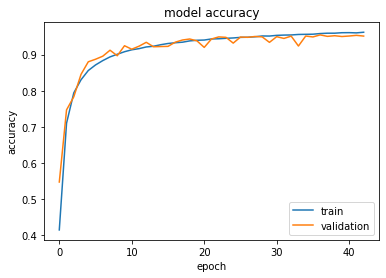

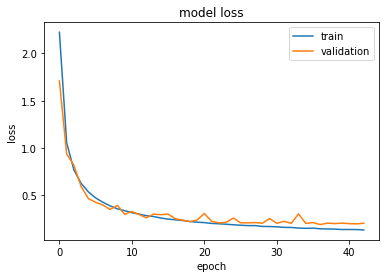

<Figure size 432x288 with 0 Axes>

In [53]:
# Plot Model Accuracy and Model Loss
# Summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
plt.savefig(os.path.join(picDir, 'hist_of_acc.png')
# Summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
plt.savefig(os.path.join(picDir, 'hist_of_lost.png')

In [0]:
# Save the model
model.save(modelPath)

In [66]:
# Evaluate model with test data
score, acc = model.evaluate(X_test, Y_test, batch_size=100)

print('Test score:', score)
print('Test accuracy:', acc)

9500/9500 [==============================] - 1s 149us/step
Test score: 0.20135177789703257
Test accuracy: 0.948736846446991


The encrypted traffic data analyzed with a trained neural network and identified as %94 correctly. 